In [1]:
from numpy.random import default_rng
from statsmodels.distributions.empirical_distribution import monotone_fn_inverter
import numpy as np
from scipy.interpolate import griddata
from scipy.stats._continuous_distns import genpareto
from scipy.stats import kendalltau
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pathlib import Path
import netCDF4 as nc
import importlib
import stme
from pathlib import Path
from datetime import datetime
import argparse
import sys
import xarray as xr

In [26]:
ds_full = xr.open_mfdataset('./Hs_max/*.nc',combine="nested",concat_dim="event",parallel=True).chunk("auto")
print(ds_full)

<xarray.Dataset>
Dimensions:        (node: 86434, event: 685, nele: 168183, nvertex: 3, single: 1)
Coordinates:
    latitude       (node) float32 dask.array<chunksize=(86434,), meta=np.ndarray>
    longitude      (node) float32 dask.array<chunksize=(86434,), meta=np.ndarray>
Dimensions without coordinates: node, event, nele, nvertex, single
Data variables:
    element        (event, nele, nvertex) int32 dask.array<chunksize=(66, 168183, 3), meta=np.ndarray>
    mesh_topology  (event, single) int32 dask.array<chunksize=(685, 1), meta=np.ndarray>
    hs_max         (event, node) float32 dask.array<chunksize=(388, 86434), meta=np.ndarray>
    tp_max         (event, node) float32 dask.array<chunksize=(388, 86434), meta=np.ndarray>
    dp_max         (event, node) float32 dask.array<chunksize=(388, 86434), meta=np.ndarray>


In [43]:
min_lon = -61.99
min_lat = 15.70
max_lon = -60.86
max_lat = 16.65
mask_lon = (ds_full.longitude >= min_lon) & (ds_full.longitude <= max_lon)
mask_lat = (ds_full.latitude >= min_lat) & (ds_full.latitude <= max_lat)
ds_cropped = ds_full.drop_dims(("single","nele")).where(mask_lon & mask_lat, drop=True).compute()
print(ds_cropped)

<xarray.Dataset>
Dimensions:    (event: 685, node: 15435)
Coordinates:
    latitude   (node) float32 16.5 16.17 16.35 16.0 ... 16.03 16.36 16.19 16.35
    longitude  (node) float32 -61.46 -61.11 -61.01 ... -61.61 -61.24 -61.61
Dimensions without coordinates: event, node
Data variables:
    hs_max     (event, node) float32 nan 0.708 1.322 nan ... 2.318 4.768 2.046
    tp_max     (event, node) float32 nan 6.289 6.024 nan ... 9.259 8.264 9.259
    dp_max     (event, node) float32 nan 157.0 127.0 nan ... 349.0 215.0 346.0


In [78]:
stm = ds.hs_max.max(dim="node")
exp = ds.hs_max/stm

In [ ]:
# working ds
ds = ds_cropped

(array([ 6., 32., 46., 32., 52., 58., 51., 59., 43., 52., 69., 58., 46.,
        37., 21., 10.,  5.,  3.,  3.,  2.]),
 array([ 1.4580001,  2.6667001,  3.8754003,  5.0841002,  6.2928004,
         7.5015006,  8.7102   ,  9.9189005, 11.127601 , 12.336301 ,
        13.545001 , 14.753701 , 15.962401 , 17.1711   , 18.3798   ,
        19.588501 , 20.797201 , 22.005901 , 23.214602 , 24.423302 ,
        25.632002 ], dtype=float32),
 <BarContainer object of 20 artists>)

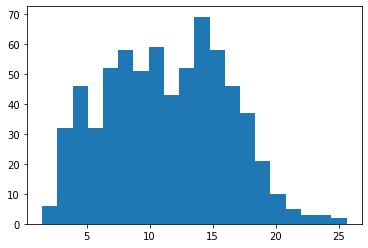

In [84]:
plt.hist(stm,20)

In [65]:
pi = 0
_filter = np.isfinite(ds.hs_max[pi,:])
x=ds.longitude[_filter]
y=ds.latitude[_filter]
c=ds.hs_max[pi,_filter]


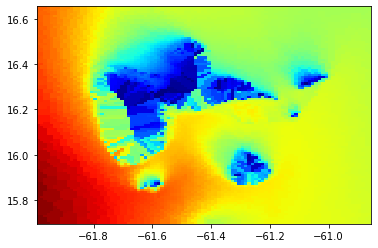

In [76]:
# define grid.
xi = np.linspace(x.min(),x.max(),100)
yi = np.linspace(y.min(),y.max(),100)
# grid the data.
zi = griddata((x, y), c, (xi[None,:], yi[:,None]), method='nearest')
plt.pcolormesh(xi,yi,zi,cmap=plt.cm.jet)
# plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)

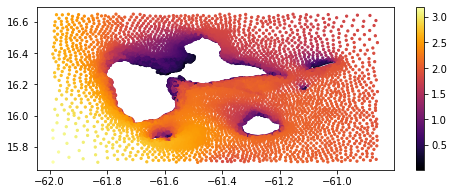

In [69]:
fig, ax = plt.subplots(figsize=(8,3),facecolor='white')
im=ax.scatter(x, y,s=5,c=c,cmap='inferno')
_mask = np.isnan(c)
ax.scatter(x[_mask],y[_mask],s=100)
fig.colorbar(im,ax=ax)